In [1]:
import collections
import hashlib
import os
import tarfile
import time
import zipfile

from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
import numpy as np
import requests
import torch
from torch import nn
from torch.utils import data

In [2]:
# @save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['aclImdb'] = (DATA_URL + 'aclImdb_v1.tar.gz', '01ada507287d82875905620988597833ad4e0903')
DATA_HUB['glove.6B.100d'] = (DATA_URL + 'glove.6B.100d.zip', 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

In [3]:

def download(name, cache_dir=os.path.join('.', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename.

    Defined in :numref:`sec_kaggle_house`"""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


def download_extract(name, folder=None):
    """Download and extract a zip/tar file.

    Defined in :numref:`sec_kaggle_house`"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir


# @save
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels.
    data_dir is like
    .
    |____aclImdb
    | |____test
    | | |____neg
    | | | |____1821_4.txt
    | | | |...
    | | |____pos
    | | | |____2828_2.txt
    | | | |...
    | |____train
    | | |____neg
    | | | |____1821_4.txt
    | | | |...
    | | |____pos
    | | | |____2828_2.txt
    | | | |..."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                #
                # each review is stored in a file
                # review is a long string
                #
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                #
                # label is used to tell the review is positive or negative
                #
                labels.append(1 if label == 'pos' else 0)
    #
    # data is like ["xxx", "xxx", ...]
    # labels is like [1, 0, ...]
    #
    return data, labels


def tokenize(lines, token='word'):
    """Split text lines into word or character tokens.

    Defined in :numref:`sec_text_preprocessing`"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)


def count_corpus(tokens):
    """Count token frequencies.

    Defined in :numref:`sec_text_preprocessing`"""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


class Vocab:
    """Vocabulary for text."""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        """Defined in :numref:`sec_text_preprocessing`"""
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs


def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences.

    Defined in :numref:`sec_machine_translation`"""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad


def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator.

    Defined in :numref:`sec_linear_concise`"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


# @save
def load_data_imdb(batch_size, num_steps):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    if os.path.isfile("./data/aclImdb_v1.tar.gz"):
        fname = "./data/aclImdb_v1.tar.gz"
        base_dir = os.path.dirname(fname)
        data_dir, ext = os.path.splitext(fname)
        if ext == '.zip':
            fp = zipfile.ZipFile(fname, 'r')
        elif ext in ('.tar', '.gz'):
            fp = tarfile.open(fname, 'r')
        else:
            assert False, 'Only zip/tar files can be extracted.'
        # todo optimize later
        # extractall is too slow,
        # so we assume that as long as there is the zip file,
        # there are the corresponding unzip files
        # fp.extractall(base_dir)
        data_dir = os.path.join(base_dir, 'aclImdb')
    else:
        data_dir = download_extract('aclImdb', 'aclImdb')
    #
    # train_data and test_data are like (["For a movie that gets no respect ...", ...], [1, 0, ...])
    #
    # tuple's first element is the review array
    # each element of the review array is a review
    #
    # tuple's second element is the label
    # 1 is positive and 0 is negative
    #
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    #
    # train_tokens and test_tokens are like [['For', 'a', 'movie', ...], ...]
    # each element of the inner array is a single word
    # each element of the outer array is a review
    #
    train_tokens = tokenize(train_data[0], token='word')
    test_tokens = tokenize(test_data[0], token='word')
    #
    # vocab.idx_to_token is an array like ["<unk>", "<pad>", "the", "a", ...]
    # each element is a word
    # vocab.token_to_idx is a map like {"<unk>": 0, "<pad>": 1, "the": 2, ...}
    # key is a word and value is its index in vocab.idx_to_token
    #
    vocab = Vocab(train_tokens, min_freq=5)
    #
    # train_features and test_features are like
    # [
    #   [  324,     2,    20,  ...,     1,     1,     1], # length : num_steps E.g. 500
    #   ...
    # ] # length: len(train_tokens) E.g. 25000 AKA. total number of reviews
    #
    # each element of the inner array is its index in vocab.token_to_idx
    #
    # elements in train_features and test_features have the same length: num_steps
    # in this case it is 500
    #
    # if inner array is longer than num_steps, it will get truncated
    # or it shorter than num_steps, it will be padded with 0
    #
    train_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    #
    # load_array put train_features and test_features into a pytorch TensorDataset
    # and returned a DataLoader as an iterator
    #
    # the iterator return data with the number of batch_size E.g. 64
    #
    train_iter = load_array((train_features, torch.tensor(train_data[1])), batch_size)
    test_iter = load_array((test_features, torch.tensor(test_data[1])), batch_size, is_train=False)
    #
    # X is like
    # [
    #   [2556, 1913, ...], # total length: 500 AKA. num_steps
    #   ...
    # ] # total length: 64 AKA. batch_size
    #
    # y is like
    # [1, 0, 1, ...] # total length: 64
    #
    for X, y in train_iter:
        print('X:', X.shape, ', y:', y.shape)  # X: torch.Size([64, 500]) , y: torch.Size([64])
        break
    print('# batches:', len(train_iter))  # batches: 391; len(train_iter) * batch_size => 391 * 64 ~ 25000 => total number of reviews

    return train_iter, test_iter, vocab


In [4]:
num_steps = 500  # sequence length
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size, num_steps)

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


In [5]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        #
        # embedding: A simple lookup table that stores embeddings of a fixed dictionary and size.
        #            This module is used to store word embeddings and retrieve them using indices.
        #            The input to the module is a list of indices, and the output is the corresponding word embeddings.
        # num_embeddings (int) AKA. vocab_size: size of the dictionary of embeddings E.g. 49347
        # embedding_dim (int)  AKA. embed_size: the size of each embedding vector    E.g. 100
        #
        # it is 49347 * 100 in this case
        #
        # there are 49347 embedding vectors and each embedding vector has 100 elements
        #
        # self.embedding.weight is like
        # [
        #  [-0.8094,  1.5452, -0.5332,  ..., -0.7949, -0.6408, -0.4228], # total length: 100
        #  ...,
        # ] # total length: 49347
        #
        self.embedding = nn.Embedding(vocab_size, embed_size)
        #
        # input_size  AKA. embed_size: The number of expected features in the input `x`
        # hidden_size AKA. num_hiddens: The number of features in the hidden state `h`
        # num_layers: Number of recurrent layers.
        # bidirectional: if it is a bidirectional rnn or not
        #
        # self.encoder
        #             .weight_ih_l0
        #             .weight_ih_l1
        #                   weight_ih_l[k]: the learnable input-hidden weights of the kth layer
        #                                   `(W_ii|W_if|W_ig|W_io)`, of shape `(4*hidden_size, input_size)` for `k = 0`.
        #                                   Otherwise, the shape is `(4*hidden_size, num_directions * hidden_size)`.
        #             .weight_ih_l0_reverse
        #             .weight_ih_l1_reverse
        #
        #             .weight_hh_l0
        #             .weight_hh_l1
        #                   weight_hh_l[k] : the learnable hidden-hidden weights of the kth layer
        #                                    `(W_hi|W_hf|W_hg|W_ho)`, of shape `(4*hidden_size, hidden_size)`.
        #             .weight_hh_l0_reverse
        #             .weight_hh_l1_reverse
        #
        #
        # self.encoder.all_weights is like
        # [
        #  [
        #    (400, 100)
        #    (400, 100)
        #    (400,)
        #    (400,)
        #  ],
        #  [
        #    (400, 100)
        #    (400, 100)
        #    (400,)
        #    (400,)
        #  ],
        #  [
        #    (400, 200)
        #    (400, 100)
        #    (400,)
        #    (400,)
        #  ],
        #  [
        #    (400, 200)
        #    (400, 100)
        #    (400,)
        #    (400,)
        #  ]
        # ] # total length: 4
        #
        #
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        #
        # Applies a linear transformation to the incoming data: :math:`y = xA^T + b`
        # in_features: size of each input sample
        # out_features: size of each output sample
        #
        # why 4 and why 2 ???
        #
        # self.decoder.weight is like
        # [
        #  [2.4826e-02,  1.9565e-02,  4.2694e-02, ...], # total length: 400
        #  ...,
        # ] # total length: 2
        #
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        #
        # The shape of `inputs` is (batch size, no. of time steps).
        # E.g. batch_size * num_steps => 64 * 500
        #
        # Because LSTM requires its input's first dimension to be the temporal dimension,
        # the input is transposed before obtaining token representations.
        #
        # embeddings is (no. of time steps, batch size, word vector dimension) => (500, 64, 100)
        #
        embeddings = self.embedding(inputs.T)
        #
        # Right now, this works only if the module is on the GPU and cuDNN is enabled.
        # Otherwise, it's a no-op.
        #
        self.encoder.flatten_parameters()
        #
        # Returns hidden states of the last hidden layer at different time steps.
        # outputs is (no. of time steps, batch size, 2 * no. of hidden units) => (500, 64, 2 * 100)
        #
        outputs, _ = self.encoder(embeddings)
        #
        # Concatenate the hidden states at the initial and final time steps
        # as the input of the fully connected layer.
        # Its shape is (batch size, 4 * no. of hidden units) => (64, 4 * 100)
        #
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        #
        # outs (64, 2)
        #
        outs = self.decoder(encoding)
        return outs

In [6]:
def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists.

    Defined in :numref:`sec_use_gpu`"""
    devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [7]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [8]:
def init_weights(module):
    #
    # perform xavier_uniform_ on each weight property
    #
    # module
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])


net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49346, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [9]:
class TokenEmbedding:
    """Token Embedding."""

    def __init__(self, embedding_name):
        """Defined in :numref:`sec_synonyms`"""
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []

        if os.path.isfile("./data/glove.6B.100d.zip"):
            fname = "./data/glove.6B.100d.zip"
            base_dir = os.path.dirname(fname)
            data_dir, ext = os.path.splitext(fname)
            if ext == '.zip':
                fp = zipfile.ZipFile(fname, 'r')
            elif ext in ('.tar', '.gz'):
                fp = tarfile.open(fname, 'r')
            else:
                assert False, 'Only zip/tar files can be extracted.'
            # todo optimize later
            # extractall is too slow,
            # so we assume that as long as there is the zip file,
            # there are the corresponding unzip files
            # fp.extractall(base_dir)
            data_dir = os.path.join(base_dir, embedding_name)
        else:
            data_dir = download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        #
        # the content of vec.txt is like,
        # happy -0.038194 -0.24487 ... -1.2526 0.071624 # total number 100 AKA. the word happy is represented by 100 float value
        # each line is a word and 100 float value
        #
        # idx_to_token is an array, each element is a token (AKA a word)
        #
        # idx_to_vec is an array like
        # [[-0.038194 -0.24487 ... -1.2526 0.071624], ...]
        # each element is the vector of the word
        #
        # token_to_idx is a map, key is token and value is its index in idx_to_token
        #
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx) for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)


glove_embedding = TokenEmbedding('glove.6B.100d')

In [10]:
#
# embeds is (49347, 100)
#
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape  # torch.Size([49347, 100])

#
# copy embeds to net.embedding.weight (49347, 100)
#
net.embedding.weight.data.copy_(embeds)
#
# not perform GD on this W
#
net.embedding.weight.requires_grad = False

lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

In [11]:

def accuracy(y_hat, y):
    """Compute the number of correct predictions.

    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))


def train_batch(net, X, y, loss, trainer, devices):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13).

    Defined in :numref:`sec_image_augmentation`"""
    #
    # X is (64, 500)
    # y is (64,)
    # so we handle 64 review data each batch
    #
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    #
    # pred (64, 2)
    #
    pred = net(X)
    #
    # l (64,)
    #
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum


class Timer:
    """Record multiple running times."""

    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


class Animator:
    """For plotting data in animation."""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)


def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]


def train(net, train_iter, test_iter, loss, trainer, num_epochs, devices=try_all_gpus()):
    """Train a model with mutiple GPUs (defined in Chapter 13).

    Defined in :numref:`sec_image_augmentation`"""
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc {metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')



KeyboardInterrupt: 

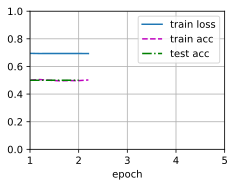

In [12]:
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu().

    Defined in :numref:`sec_use_gpu`"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')


# @save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')